# QAT Training Statistics Analysis

This notebook analyzes the training statistics from the Quantization-Aware Training (QAT) of GPT-2.

## Contents
1. Load and inspect training data
2. Training loss analysis
3. Validation loss analysis
4. Memory usage patterns
5. Learning rate schedule
6. Training efficiency metrics
7. Convergence analysis

In [1]:
# Import required libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load and Inspect Training Data

In [11]:
# Load training statistics
def load_training_stats(filepath='cpt_training_stats_20250914_211018.json'):
    # Try to find the most recent file if default doesn't exist
    import os
    import glob
    
    if not os.path.exists(filepath):
        stats_files = glob.glob('cpt_training_stats_*.json')
        if stats_files:
            filepath = max(stats_files, key=os.path.getctime)
            print(f"Using most recent stats file: {filepath}")

    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        print(f"✅ Successfully loaded training stats from {filepath}")
        return data
    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
        print("Please ensure the training has been completed and stats file exists.")
        return None
    except json.JSONDecodeError:
        print(f"❌ Invalid JSON in {filepath}")
        return None

# Load the data
stats = load_training_stats()

if stats:
    print(f"\n📊 Training Statistics Overview:")
    # Check for new format keys
    if 'iteration_losses' in stats:
        print(f"  - Total iterations: {len(stats['iteration_losses'])}")
    elif 'iterations' in stats:
        print(f"  - Total iterations: {len(stats['iterations'])}")
    print(f"  - Keys available: {list(stats.keys())}")

    # Show best validation loss if available
    if 'best_val_loss' in stats:
        print(f"  - Best validation loss: {stats['best_val_loss']:.4f}")
    if 'best_iteration' in stats:
        print(f"  - Best iteration: {stats['best_iteration']}")

✅ Successfully loaded training stats from cpt_training_stats_20250914_211018.json

📊 Training Statistics Overview:
  - Total iterations: 3000
  - Keys available: ['iteration_losses', 'validation_losses', 'bit_width_history', 'cycle_metrics', 'best_val_loss', 'best_iteration', 'final_loss']
  - Best validation loss: 1.0543
  - Best iteration: 1700


In [12]:
# Convert to DataFrame for easier analysis
if stats:
    # Handle both old and new format
    if 'iteration_losses' in stats:
        # New format - get the base length from iteration_losses
        base_len = len(stats['iteration_losses'])
        
        # Helper function to normalize array length
        def normalize_array(arr, target_len, default_val=None):
            if arr is None:
                return [default_val] * target_len
            arr_len = len(arr)
            if arr_len == target_len:
                return arr
            elif arr_len < target_len:
                # Pad with default value
                return list(arr) + [default_val] * (target_len - arr_len)
            else:
                # Truncate to target length
                return arr[:target_len]
        
        # Normalize all arrays to base_len
        df = pd.DataFrame({
            'iteration': list(range(base_len)),
            'train_loss': stats['iteration_losses'],
            'val_loss': normalize_array(stats.get('validation_losses'), base_len),
            'bit_width': normalize_array(stats.get('bit_width_usage') or stats.get('bit_width_history'), base_len),
            'learning_rate': normalize_array(stats.get('learning_rates'), base_len),
            'memory_mb': normalize_array(stats.get('memory_usage'), base_len)
        })
    else:
        # Old format
        base_len = len(stats.get('train_losses', []))
        
        def normalize_array(arr, target_len, default_val=None):
            if arr is None:
                return [default_val] * target_len
            arr_len = len(arr)
            if arr_len == target_len:
                return arr
            elif arr_len < target_len:
                return list(arr) + [default_val] * (target_len - arr_len)
            else:
                return arr[:target_len]
        
        df = pd.DataFrame({
            'iteration': stats.get('iterations', list(range(base_len))),
            'train_loss': stats.get('train_losses', []),
            'val_loss': normalize_array(stats.get('val_losses'), base_len),
            'bit_width': normalize_array(stats.get('bit_width_history'), base_len),
            'learning_rate': normalize_array(stats.get('learning_rates'), base_len),
            'memory_mb': normalize_array(stats.get('memory_usage'), base_len)
        })
    
    # Display basic statistics
    print("\n📈 Dataset Summary:")
    print(df.describe())
    
    print("\n🔍 First 5 rows:")
    display(df.head())
    
    print("\n🔍 Last 5 rows:")
    display(df.tail())
    
    # Show best iteration info if available
    if 'best_val_loss' in stats and 'best_iteration' in stats:
        print(f"\n🏆 Best Performance:")
        print(f"  - Best validation loss: {stats['best_val_loss']:.4f}")
        print(f"  - Achieved at iteration: {stats['best_iteration']}")


📈 Dataset Summary:
         iteration   train_loss   val_loss   bit_width
count  3000.000000  3000.000000  29.000000  3000.00000
mean   1499.500000     1.570633   1.089632     5.48000
std     866.169729     0.874219   0.033885     2.07148
min       0.000000     0.632237   1.054327     2.00000
25%     749.750000     1.040153   1.060641     4.00000
50%    1499.500000     1.355609   1.075458     6.00000
75%    2249.250000     1.923756   1.108892     8.00000
max    2999.000000    12.711207   1.156684     8.00000

🔍 First 5 rows:


,iteration,train_loss,val_loss,bit_width,learning_rate,memory_mb
0,0,12.220345,1.151025,8,None,None
1,1,12.408894,1.100692,8,None,None
2,2,12.507939,1.084515,8,None,None
3,3,12.711207,1.075458,8,None,None
4,4,3.573253,1.066217,8,None,None



🔍 Last 5 rows:


,iteration,train_loss,val_loss,bit_width,learning_rate,memory_mb
2995,2995,0.632237,NaN,8,None,None
2996,2996,0.797224,NaN,8,None,None
2997,2997,0.793656,NaN,8,None,None
2998,2998,0.662590,NaN,8,None,None
2999,2999,0.742906,NaN,8,None,None



🏆 Best Performance:
  - Best validation loss: 1.0543
  - Achieved at iteration: 1700


## 2. Training Loss Analysis

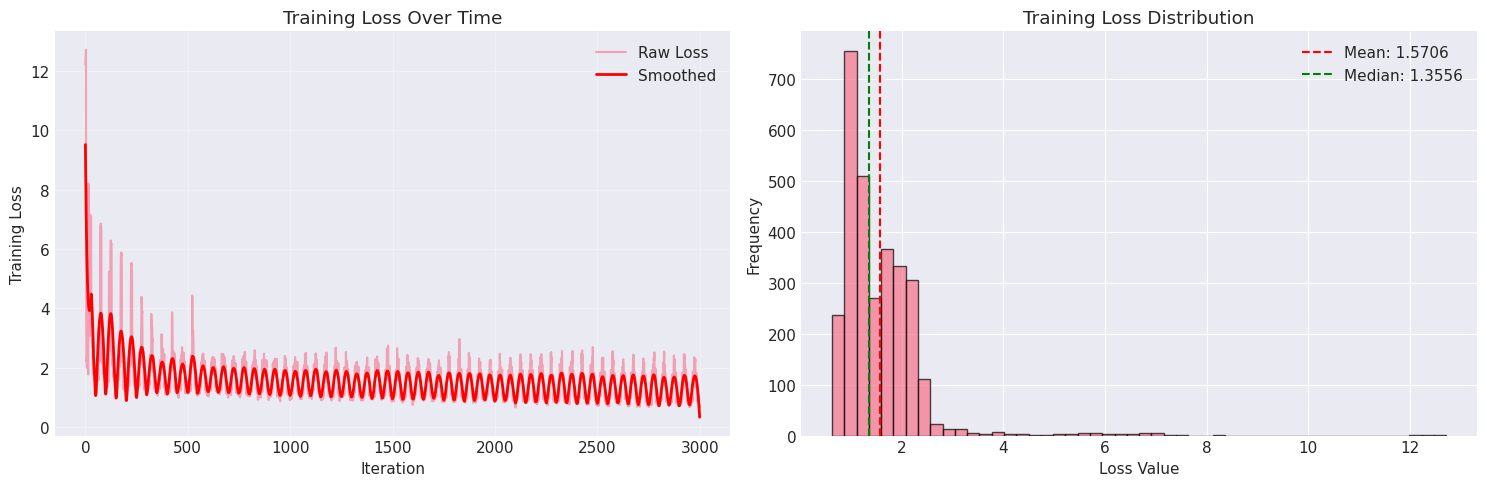


📊 Training Loss Metrics:
  - Initial loss (first 10 iter): 6.4614
  - Final loss (last 10 iter): 0.8273
  - Improvement: 87.20%
  - Minimum loss: 0.6322 at iteration 2995


In [13]:
if stats:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Raw training loss
    axes[0].plot(df['iteration'], df['train_loss'], alpha=0.6, label='Raw Loss')
    
    # Add smoothed line if enough data points
    if len(df) > 50:
        window_size = min(51, len(df) // 10 * 2 + 1)  # Ensure odd window size
        smoothed = savgol_filter(df['train_loss'].dropna(), window_size, 3)
        axes[0].plot(df['iteration'][:len(smoothed)], smoothed, 'r-', linewidth=2, label='Smoothed')
    
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Loss distribution
    axes[1].hist(df['train_loss'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(df['train_loss'].mean(), color='red', linestyle='--', label=f'Mean: {df["train_loss"].mean():.4f}')
    axes[1].axvline(df['train_loss'].median(), color='green', linestyle='--', label=f'Median: {df["train_loss"].median():.4f}')
    axes[1].set_xlabel('Loss Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Training Loss Distribution')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate improvement metrics
    initial_loss = df['train_loss'].iloc[:10].mean()
    final_loss = df['train_loss'].iloc[-10:].mean()
    improvement = (initial_loss - final_loss) / initial_loss * 100
    
    print(f"\n📊 Training Loss Metrics:")
    print(f"  - Initial loss (first 10 iter): {initial_loss:.4f}")
    print(f"  - Final loss (last 10 iter): {final_loss:.4f}")
    print(f"  - Improvement: {improvement:.2f}%")
    print(f"  - Minimum loss: {df['train_loss'].min():.4f} at iteration {df.loc[df['train_loss'].idxmin(), 'iteration']}")

## 3. Validation Loss Analysis

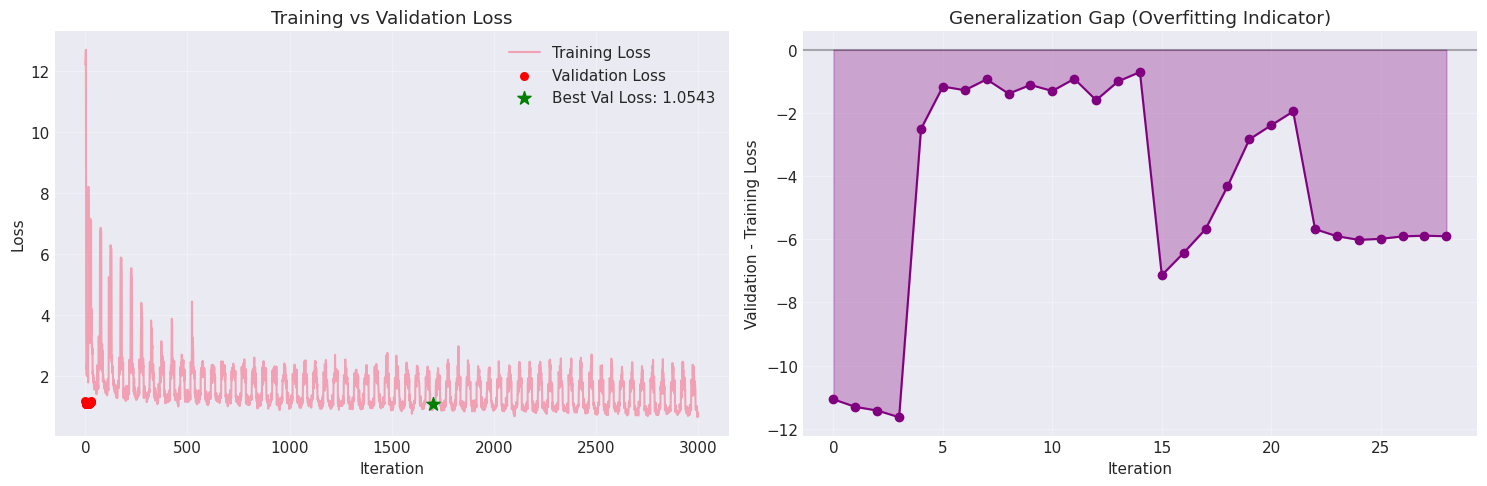


📊 Validation Metrics:
  - Best validation loss: 1.0543 at iteration 1700
  - Average generalization gap: -4.5320
  - Final generalization gap: -5.9061
  ⚠️ Warning: Increasing generalization gap (potential overfitting)


In [14]:
if stats and ('validation_losses' in stats or 'val_losses' in stats):
    # Filter out None values for validation loss
    val_df = df[df['val_loss'].notna()].copy()
    
    if not val_df.empty:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Training vs Validation Loss
        axes[0].plot(df['iteration'], df['train_loss'], alpha=0.6, label='Training Loss')
        axes[0].scatter(val_df['iteration'], val_df['val_loss'], color='red', s=30, label='Validation Loss', zorder=5)
        axes[0].plot(val_df['iteration'], val_df['val_loss'], 'r--', alpha=0.5)
        
        # Mark best validation loss if available
        if 'best_val_loss' in stats and 'best_iteration' in stats:
            axes[0].scatter(stats['best_iteration'], stats['best_val_loss'], 
                          color='green', s=100, marker='*', label=f'Best Val Loss: {stats["best_val_loss"]:.4f}', zorder=10)
        
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training vs Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Overfitting Analysis (Gap between train and val)
        # Interpolate training loss at validation points
        train_at_val = np.interp(val_df['iteration'], df['iteration'], df['train_loss'])
        gap = val_df['val_loss'].values - train_at_val
        
        axes[1].plot(val_df['iteration'], gap, 'o-', color='purple')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].fill_between(val_df['iteration'], 0, gap, alpha=0.3, color='purple')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Validation - Training Loss')
        axes[1].set_title('Generalization Gap (Overfitting Indicator)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate metrics
        print(f"\n📊 Validation Metrics:")
        if 'best_val_loss' in stats and 'best_iteration' in stats:
            print(f"  - Best validation loss: {stats['best_val_loss']:.4f} at iteration {stats['best_iteration']}")
        else:
            print(f"  - Best validation loss: {val_df['val_loss'].min():.4f} at iteration {val_df.loc[val_df['val_loss'].idxmin(), 'iteration']}")
        print(f"  - Average generalization gap: {gap.mean():.4f}")
        print(f"  - Final generalization gap: {gap[-1]:.4f}")
        
        if gap[-1] > gap[0]:
            print(f"  ⚠️ Warning: Increasing generalization gap (potential overfitting)")
        else:
            print(f"  ✅ Good: Stable or decreasing generalization gap")
    else:
        print("No validation data available in the statistics.")
else:
    print("No validation losses key found in the statistics.")

## 4. Memory Usage Analysis

In [15]:
if stats and 'memory_usage' in stats:
    mem_df = df[df['memory_mb'].notna()].copy()
    
    if not mem_df.empty:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Memory usage over time
        axes[0].plot(mem_df['iteration'], mem_df['memory_mb'], 'b-', alpha=0.7)
        axes[0].fill_between(mem_df['iteration'], mem_df['memory_mb'].min(), mem_df['memory_mb'], alpha=0.3)
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Memory Usage (MB)')
        axes[0].set_title('GPU Memory Usage Over Time')
        axes[0].grid(True, alpha=0.3)
        
        # Add memory leak detection line
        z = np.polyfit(mem_df['iteration'], mem_df['memory_mb'], 1)
        p = np.poly1d(z)
        axes[0].plot(mem_df['iteration'], p(mem_df['iteration']), "r--", alpha=0.5, label=f'Trend: {z[0]:.2f} MB/iter')
        axes[0].legend()
        
        # Plot 2: Memory distribution
        axes[1].hist(mem_df['memory_mb'], bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[1].axvline(mem_df['memory_mb'].mean(), color='red', linestyle='--', label=f'Mean: {mem_df["memory_mb"].mean():.0f} MB')
        axes[1].set_xlabel('Memory Usage (MB)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Memory Usage Distribution')
        axes[1].legend()
        
        # Plot 3: Memory vs Loss correlation
        axes[2].scatter(mem_df['memory_mb'], mem_df['train_loss'], alpha=0.5)
        axes[2].set_xlabel('Memory Usage (MB)')
        axes[2].set_ylabel('Training Loss')
        axes[2].set_title('Memory Usage vs Training Loss')
        axes[2].grid(True, alpha=0.3)
        
        # Add correlation coefficient
        corr = mem_df['memory_mb'].corr(mem_df['train_loss'])
        axes[2].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[2].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        # Memory statistics
        print(f"\n💾 Memory Usage Statistics:")
        print(f"  - Average memory: {mem_df['memory_mb'].mean():.0f} MB")
        print(f"  - Peak memory: {mem_df['memory_mb'].max():.0f} MB")
        print(f"  - Memory variance: {mem_df['memory_mb'].std():.0f} MB")
        print(f"  - Memory growth rate: {z[0]:.4f} MB/iteration")
        
        if abs(z[0]) < 0.1:
            print(f"  ✅ No significant memory leak detected")
        else:
            print(f"  ⚠️ Potential memory leak: {z[0]:.4f} MB/iteration growth")

## 5. Learning Rate Schedule Analysis

In [16]:
if stats and 'learning_rates' in stats:
    lr_df = df[df['learning_rate'].notna()].copy()
    
    if not lr_df.empty:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Learning rate schedule
        axes[0].plot(lr_df['iteration'], lr_df['learning_rate'], 'g-', linewidth=2)
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Learning Rate')
        axes[0].set_title('Learning Rate Schedule (Cosine Annealing)')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_yscale('log')
        
        # Plot 2: Learning rate vs Loss
        scatter = axes[1].scatter(lr_df['learning_rate'], lr_df['train_loss'], 
                                 c=lr_df['iteration'], cmap='viridis', alpha=0.6)
        axes[1].set_xlabel('Learning Rate')
        axes[1].set_ylabel('Training Loss')
        axes[1].set_title('Learning Rate vs Training Loss')
        axes[1].set_xscale('log')
        axes[1].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('Iteration')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 Learning Rate Statistics:")
        print(f"  - Initial LR: {lr_df['learning_rate'].iloc[0]:.6f}")
        print(f"  - Final LR: {lr_df['learning_rate'].iloc[-1]:.6f}")
        print(f"  - LR reduction: {(1 - lr_df['learning_rate'].iloc[-1]/lr_df['learning_rate'].iloc[0])*100:.2f}%")

## 6. Training Efficiency Metrics

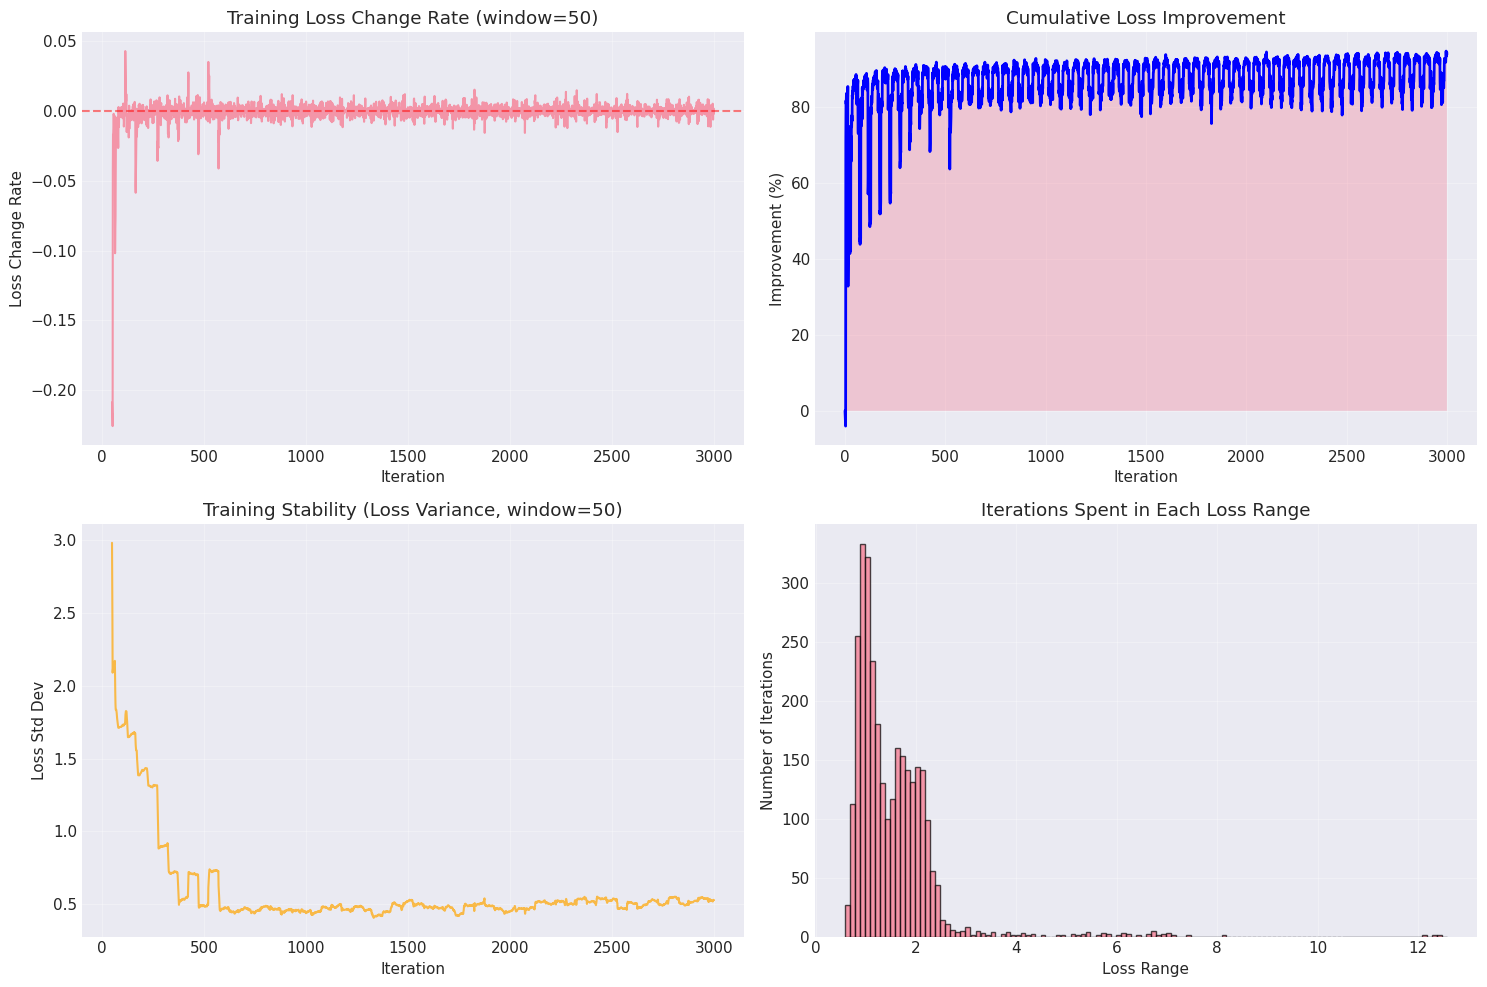


⚡ Training Efficiency Metrics:
  - Early training improvement (first 25%): 90.29%
  - Late training improvement (last 25%): 0.85%
  - Average loss variance: 0.5893
  - Training stability score: 0.629 (higher is better)
  ✅ Efficient early training - most learning happened early


In [17]:
if stats:
    # Calculate various efficiency metrics
    
    # Loss reduction rate
    window = min(50, len(df) // 10)
    loss_changes = df['train_loss'].rolling(window=window).mean().diff()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Loss reduction rate
    axes[0, 0].plot(df['iteration'][window:], loss_changes[window:], alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss Change Rate')
    axes[0, 0].set_title(f'Training Loss Change Rate (window={window})')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative loss reduction
    cumulative_improvement = (df['train_loss'].iloc[0] - df['train_loss']) / df['train_loss'].iloc[0] * 100
    axes[0, 1].plot(df['iteration'], cumulative_improvement, 'b-', linewidth=2)
    axes[0, 1].fill_between(df['iteration'], 0, cumulative_improvement, alpha=0.3)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Improvement (%)')
    axes[0, 1].set_title('Cumulative Loss Improvement')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Training stability (loss variance over windows)
    loss_variance = df['train_loss'].rolling(window=window).std()
    axes[1, 0].plot(df['iteration'][window:], loss_variance[window:], 'orange', alpha=0.7)
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Loss Std Dev')
    axes[1, 0].set_title(f'Training Stability (Loss Variance, window={window})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Iterations per loss unit
    loss_ranges = np.arange(df['train_loss'].min(), df['train_loss'].max(), 0.1)
    iterations_needed = []
    for i in range(len(loss_ranges)-1):
        mask = (df['train_loss'] >= loss_ranges[i]) & (df['train_loss'] < loss_ranges[i+1])
        iterations_needed.append(mask.sum())
    
    axes[1, 1].bar(loss_ranges[:-1], iterations_needed, width=0.09, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Loss Range')
    axes[1, 1].set_ylabel('Number of Iterations')
    axes[1, 1].set_title('Iterations Spent in Each Loss Range')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate efficiency metrics
    early_improvement = cumulative_improvement.iloc[len(df)//4]
    late_improvement = cumulative_improvement.iloc[-1] - cumulative_improvement.iloc[3*len(df)//4]
    
    print(f"\n⚡ Training Efficiency Metrics:")
    print(f"  - Early training improvement (first 25%): {early_improvement:.2f}%")
    print(f"  - Late training improvement (last 25%): {late_improvement:.2f}%")
    print(f"  - Average loss variance: {loss_variance.mean():.4f}")
    print(f"  - Training stability score: {1/(1+loss_variance.mean()):.3f} (higher is better)")
    
    if early_improvement > late_improvement * 2:
        print(f"  ✅ Efficient early training - most learning happened early")
    else:
        print(f"  📈 Continued learning throughout training")

## 7. Convergence Analysis

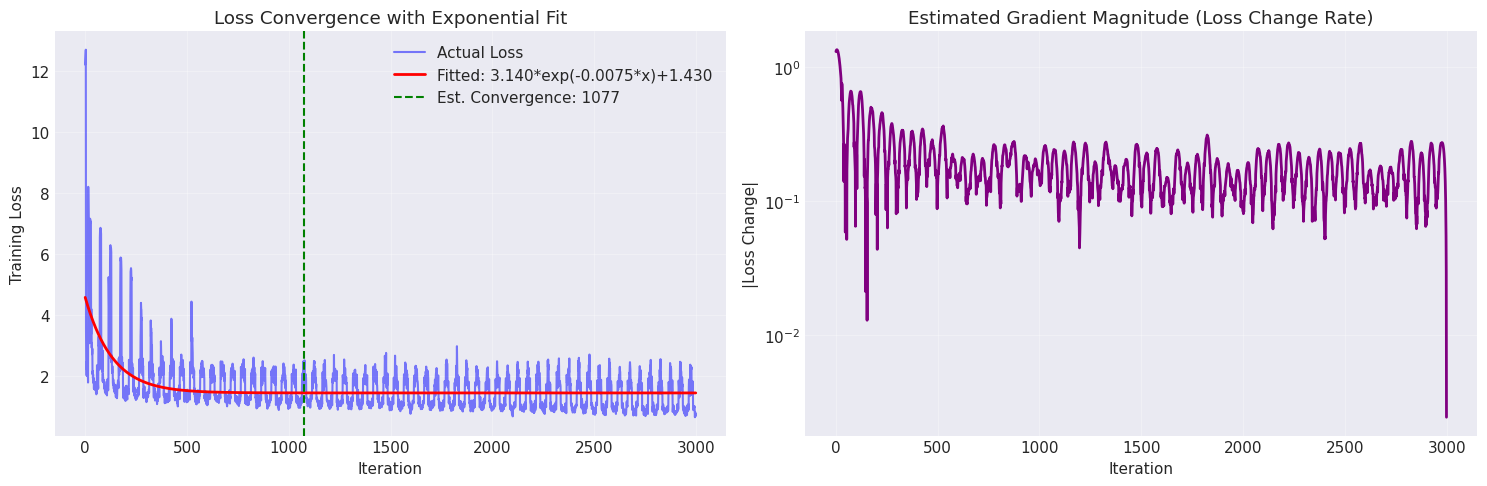


🎯 Convergence Analysis:
  - Final loss stability (std of last 100): 0.53021
  - Final loss mean (last 100): 1.2748
  - Exponential decay rate: 0.00748
  - Asymptotic loss (predicted): 1.4301
  - Estimated convergence iteration: 1077
  ✅ Model has likely converged
  📈 Training still showing variation (may benefit from more iterations)


In [18]:
if stats:
    # Convergence analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Loss convergence with exponential fit
    from scipy.optimize import curve_fit
    
    def exp_decay(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    try:
        # Fit exponential decay
        x_data = df['iteration'].values
        y_data = df['train_loss'].values
        
        # Initial guess
        p0 = [y_data[0] - y_data[-1], 0.001, y_data[-1]]
        popt, pcov = curve_fit(exp_decay, x_data, y_data, p0=p0, maxfev=5000)
        
        # Plot actual and fitted
        axes[0].plot(x_data, y_data, 'b-', alpha=0.5, label='Actual Loss')
        axes[0].plot(x_data, exp_decay(x_data, *popt), 'r-', linewidth=2, 
                    label=f'Fitted: {popt[0]:.3f}*exp(-{popt[1]:.4f}*x)+{popt[2]:.3f}')
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Training Loss')
        axes[0].set_title('Loss Convergence with Exponential Fit')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Estimate convergence point (where decay is < 0.001 per iteration)
        convergence_iter = -np.log(0.001 / popt[0]) / popt[1] if popt[1] > 0 else np.inf
        if convergence_iter < len(df) * 2:
            axes[0].axvline(x=convergence_iter, color='green', linestyle='--', 
                          label=f'Est. Convergence: {convergence_iter:.0f}')
            axes[0].legend()
            
    except:
        axes[0].plot(df['iteration'], df['train_loss'], 'b-', alpha=0.7)
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('Training Loss')
        axes[0].set_title('Training Loss (Exponential fit failed)')
        axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Gradient magnitude estimate (loss changes)
    grad_estimate = np.abs(df['train_loss'].diff())
    window_size = min(51, len(df) // 10 * 2 + 1)
    if len(grad_estimate) > window_size:
        grad_smooth = savgol_filter(grad_estimate.dropna(), window_size, 3)
        axes[1].plot(df['iteration'][1:len(grad_smooth)+1], grad_smooth, 'purple', linewidth=2)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('|Loss Change|')
    axes[1].set_title('Estimated Gradient Magnitude (Loss Change Rate)')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Convergence metrics
    last_100_std = df['train_loss'].iloc[-100:].std() if len(df) > 100 else df['train_loss'].std()
    last_100_mean = df['train_loss'].iloc[-100:].mean() if len(df) > 100 else df['train_loss'].mean()
    
    print(f"\n🎯 Convergence Analysis:")
    print(f"  - Final loss stability (std of last 100): {last_100_std:.5f}")
    print(f"  - Final loss mean (last 100): {last_100_mean:.4f}")
    
    if 'popt' in locals():
        print(f"  - Exponential decay rate: {popt[1]:.5f}")
        print(f"  - Asymptotic loss (predicted): {popt[2]:.4f}")
        if convergence_iter < len(df) * 2:
            print(f"  - Estimated convergence iteration: {convergence_iter:.0f}")
            if convergence_iter < len(df):
                print(f"  ✅ Model has likely converged")
            else:
                print(f"  📈 Model approaching convergence")
    
    if last_100_std < 0.01:
        print(f"  ✅ Training has converged (low variance in final iterations)")
    else:
        print(f"  📈 Training still showing variation (may benefit from more iterations)")

## 8. Summary and Recommendations

In [19]:
if stats:
    print("="*60)
    print("📊 TRAINING SUMMARY REPORT")
    print("="*60)
    
    # Key metrics
    print("\n🔑 Key Metrics:")
    print(f"  - Total iterations: {len(df)}")
    print(f"  - Final training loss: {df['train_loss'].iloc[-1]:.4f}")
    print(f"  - Best training loss: {df['train_loss'].min():.4f}")
    print(f"  - Total improvement: {(1 - df['train_loss'].iloc[-1]/df['train_loss'].iloc[0])*100:.2f}%")
    
    # Check for best_val_loss and best_iteration in stats directly
    if 'best_val_loss' in stats and 'best_iteration' in stats:
        print(f"  - Best validation loss: {stats['best_val_loss']:.4f}")
        print(f"  - Best iteration: {stats['best_iteration']}")
    elif ('validation_losses' in stats or 'val_losses' in stats) and any(v is not None for v in (stats.get('validation_losses', []) or stats.get('val_losses', []))):
        val_df = df[df['val_loss'].notna()]
        if not val_df.empty:
            print(f"  - Best validation loss: {val_df['val_loss'].min():.4f}")
            print(f"  - Final validation loss: {val_df['val_loss'].iloc[-1]:.4f}")
    
    # Bit-width information if available
    if 'bit_width_usage' in stats or 'bit_width' in df.columns:
        bit_data = stats.get('bit_width_usage', df['bit_width'].dropna().tolist() if 'bit_width' in df.columns else [])
        if bit_data:
            print(f"  - Bit-width range: {min(bit_data)}-{max(bit_data)} bits")
            print(f"  - Average bit-width: {np.mean(bit_data):.2f} bits")
    
    # Training quality assessment
    print("\n✅ Training Quality Assessment:")
    
    quality_score = 0
    max_score = 0
    
    # Check 1: Loss improvement
    improvement = (1 - df['train_loss'].iloc[-1]/df['train_loss'].iloc[0])
    max_score += 1
    if improvement > 0.3:
        print(f"  ✓ Good loss improvement ({improvement*100:.1f}%)")
        quality_score += 1
    else:
        print(f"  ✗ Limited loss improvement ({improvement*100:.1f}%)")
    
    # Check 2: Training stability
    final_std = df['train_loss'].iloc[-100:].std() if len(df) > 100 else df['train_loss'].std()
    max_score += 1
    if final_std < 0.05:
        print(f"  ✓ Stable training (std={final_std:.4f})")
        quality_score += 1
    else:
        print(f"  ✗ Unstable training (std={final_std:.4f})")
    
    # Check 3: No memory leaks
    if 'memory_usage' in stats:
        mem_df = df[df['memory_mb'].notna()]
        if not mem_df.empty:
            z = np.polyfit(mem_df['iteration'], mem_df['memory_mb'], 1)
            max_score += 1
            if abs(z[0]) < 0.5:
                print(f"  ✓ No memory leaks detected")
                quality_score += 1
            else:
                print(f"  ✗ Potential memory leak ({z[0]:.2f} MB/iter)")
    
    # Check 4: Convergence
    max_score += 1
    if final_std < 0.01:
        print(f"  ✓ Training converged")
        quality_score += 1
    else:
        print(f"  ✗ Training not fully converged")
    
    # Check 5: Validation performance (if best_val_loss available)
    if 'best_val_loss' in stats:
        max_score += 1
        # Check if validation loss is reasonable compared to training loss
        best_train = df['train_loss'].min()
        gap_ratio = (stats['best_val_loss'] - best_train) / best_train if best_train > 0 else float('inf')
        if gap_ratio < 0.2:  # Less than 20% gap
            print(f"  ✓ Good generalization (gap ratio: {gap_ratio:.2%})")
            quality_score += 1
        else:
            print(f"  ✗ Large generalization gap (gap ratio: {gap_ratio:.2%})")
    
    # Overall score
    print(f"\n🏆 Overall Training Quality Score: {quality_score}/{max_score} ({quality_score/max_score*100:.0f}%)")
    
    # Recommendations
    print("\n💡 Recommendations:")
    
    if final_std > 0.01:
        print("  • Consider training for more iterations to achieve full convergence")
    
    if 'validation_losses' in stats or 'val_losses' in stats:
        val_df = df[df['val_loss'].notna()]
        if not val_df.empty:
            train_at_val = np.interp(val_df['iteration'], df['iteration'], df['train_loss'])
            final_gap = val_df['val_loss'].iloc[-1] - train_at_val[-1]
            if final_gap > 0.5:
                print("  • High generalization gap - consider regularization or more data")
    
    if improvement < 0.2:
        print("  • Limited improvement - consider adjusting learning rate or model architecture")
    
    if 'memory_usage' in stats and 'z' in locals() and abs(z[0]) > 0.5:
        print("  • Memory leak detected - review memory management in training loop")
    
    if 'best_iteration' in stats and stats['best_iteration'] < len(df) * 0.7:
        print(f"  • Early stopping might be beneficial - best performance at iteration {stats['best_iteration']} ({stats['best_iteration']/len(df)*100:.1f}% through training)")
    
    if quality_score == max_score:
        print("  • Excellent training run! Model is ready for deployment.")
    
    print("\n" + "="*60)

📊 TRAINING SUMMARY REPORT

🔑 Key Metrics:
  - Total iterations: 3000
  - Final training loss: 0.7429
  - Best training loss: 0.6322
  - Total improvement: 93.92%
  - Best validation loss: 1.0543
  - Best iteration: 1700
  - Bit-width range: 2-8 bits
  - Average bit-width: 5.48 bits

✅ Training Quality Assessment:
  ✓ Good loss improvement (93.9%)
  ✗ Unstable training (std=0.5302)
  ✗ Training not fully converged
  ✗ Large generalization gap (gap ratio: 66.76%)

🏆 Overall Training Quality Score: 1/4 (25%)

💡 Recommendations:
  • Consider training for more iterations to achieve full convergence
  • Early stopping might be beneficial - best performance at iteration 1700 (56.7% through training)



## 9. CPT (Cyclic Precision Training) Analysis

This section analyzes statistics from Cyclic Precision Training if available.

In [20]:
# Load CPT training statistics
def load_cpt_stats(filepath=None):
    """Load CPT training statistics from JSON file."""
    if filepath is None:
        # Try to find the most recent CPT stats file
        import glob
        import os
        cpt_files = glob.glob('cpt_training_stats_*.json')
        if not cpt_files:
            cpt_files = glob.glob('part2_cyclic_precision/cpt_training_stats_*.json')
        
        if cpt_files:
            # Get the most recent file
            filepath = max(cpt_files, key=os.path.getctime)
            print(f"Found CPT stats file: {filepath}")
        else:
            print("No CPT training statistics file found")
            return None
    
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        print(f"✅ Successfully loaded CPT stats from {filepath}")
        return data
    except Exception as e:
        print(f"❌ Error loading CPT stats: {e}")
        return None

# Try to load CPT stats
cpt_stats = load_cpt_stats()

if cpt_stats:
    print(f"\n📊 CPT Training Statistics Overview:")
    print(f"  - Total iterations: {len(cpt_stats.get('iteration_losses', []))}")
    print(f"  - Keys available: {list(cpt_stats.keys())}")

Found CPT stats file: cpt_training_stats_20250914_211018.json
✅ Successfully loaded CPT stats from cpt_training_stats_20250914_211018.json

📊 CPT Training Statistics Overview:
  - Total iterations: 3000
  - Keys available: ['iteration_losses', 'validation_losses', 'bit_width_history', 'cycle_metrics', 'best_val_loss', 'best_iteration', 'final_loss']


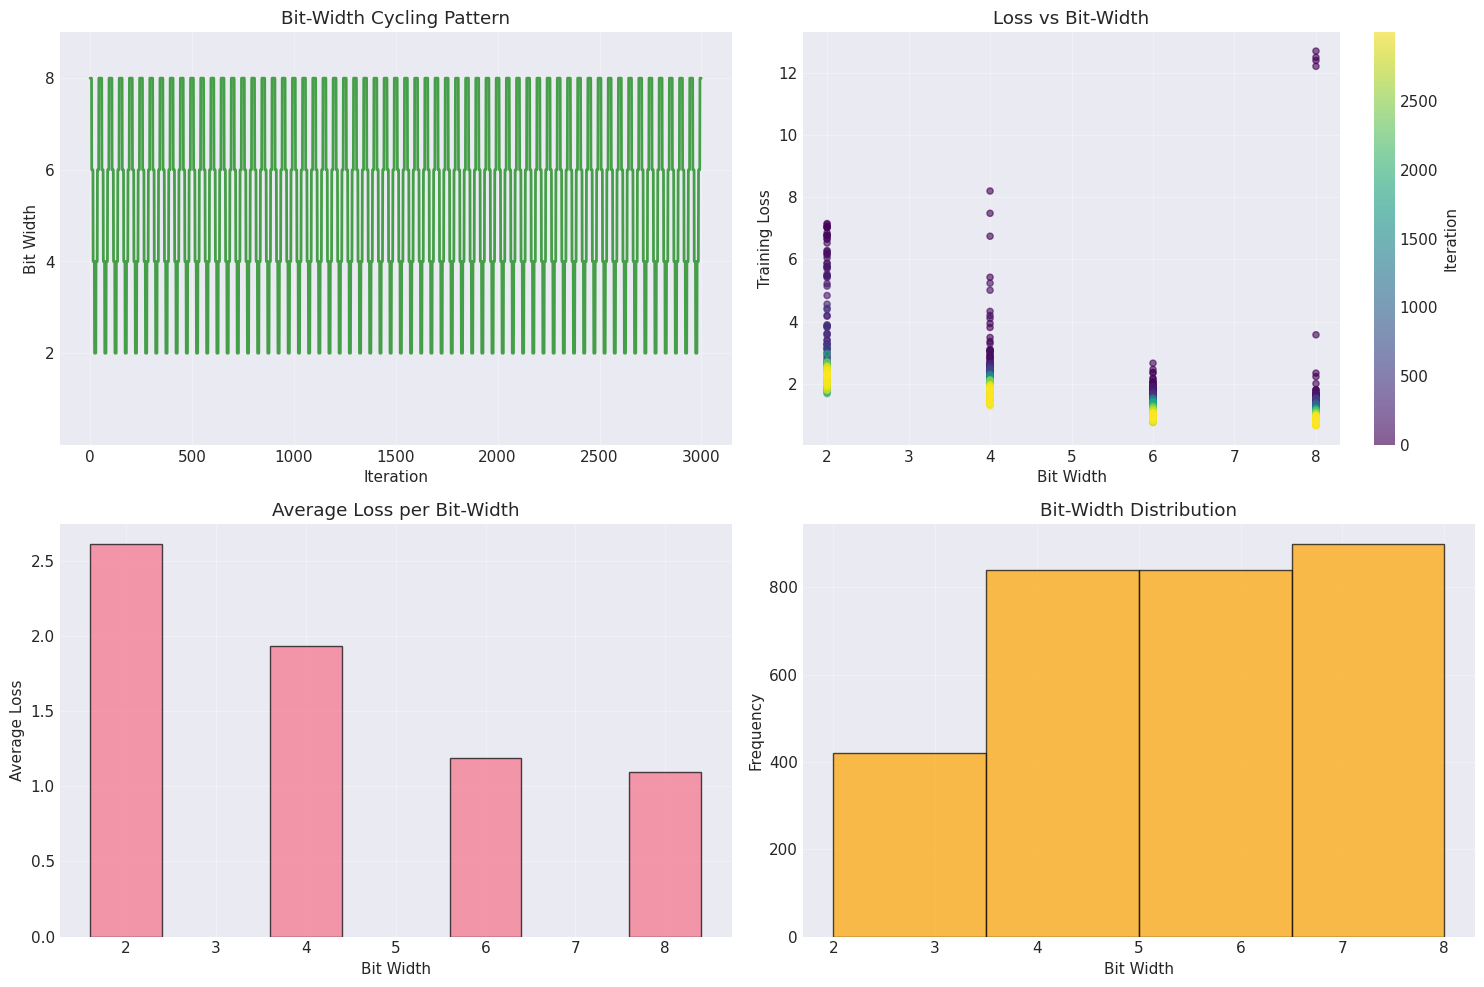


🔄 CPT Bit-Width Statistics:
  - Unique bit widths used: [2, 4, 6, 8]
  - Most common bit width: 8
  - Average bit width: 5.48

📊 Loss per Bit-Width:
  - 2-bit: 2.6161
  - 4-bit: 1.9366
  - 6-bit: 1.1896
  - 8-bit: 1.0968

🏆 Best CPT Performance:
  - Best validation loss: 1.0543
  - Achieved at iteration: 1700
  - Bit-width at best iteration: 8


In [21]:
# Analyze CPT bit-width cycling patterns
if cpt_stats:
    # Check for bit_width_usage (new format) or bit_width_history (old format)
    bit_history = cpt_stats.get('bit_width_usage', cpt_stats.get('bit_width_history', []))
    
    if bit_history:
        iterations = list(range(len(bit_history)))
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Bit-width over time
        axes[0, 0].plot(iterations, bit_history, 'g-', linewidth=2, alpha=0.7)
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('Bit Width')
        axes[0, 0].set_title('Bit-Width Cycling Pattern')
        axes[0, 0].set_ylim([0, max(bit_history) + 1])
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_yticks(sorted(set(bit_history)))
        
        # Plot 2: Loss vs Bit-width
        losses = cpt_stats.get('iteration_losses', cpt_stats.get('train_losses', []))[:len(bit_history)]
        
        if losses:
            # Create scatter plot colored by iteration
            scatter = axes[0, 1].scatter(bit_history, losses, c=iterations, 
                                        cmap='viridis', alpha=0.6, s=20)
            axes[0, 1].set_xlabel('Bit Width')
            axes[0, 1].set_ylabel('Training Loss')
            axes[0, 1].set_title('Loss vs Bit-Width')
            axes[0, 1].grid(True, alpha=0.3)
            plt.colorbar(scatter, ax=axes[0, 1], label='Iteration')
            
            # Calculate average loss per bit-width
            bit_values = sorted(set(bit_history))
            avg_losses = []
            for bit in bit_values:
                bit_losses = [losses[i] for i, b in enumerate(bit_history) if b == bit]
                avg_losses.append(np.mean(bit_losses))
            
            axes[1, 0].bar(bit_values, avg_losses, alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Bit Width')
            axes[1, 0].set_ylabel('Average Loss')
            axes[1, 0].set_title('Average Loss per Bit-Width')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Plot 4: Bit-width distribution
            axes[1, 1].hist(bit_history, bins=len(set(bit_history)), 
                           alpha=0.7, edgecolor='black', color='orange')
            axes[1, 1].set_xlabel('Bit Width')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Bit-Width Distribution')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print(f"\n🔄 CPT Bit-Width Statistics:")
        print(f"  - Unique bit widths used: {sorted(set(bit_history))}")
        print(f"  - Most common bit width: {max(set(bit_history), key=bit_history.count)}")
        print(f"  - Average bit width: {np.mean(bit_history):.2f}")
        
        if losses:
            print(f"\n📊 Loss per Bit-Width:")
            for bit, avg_loss in zip(bit_values, avg_losses):
                print(f"  - {bit}-bit: {avg_loss:.4f}")
        
        # Show best performance if available
        if 'best_val_loss' in cpt_stats and 'best_iteration' in cpt_stats:
            print(f"\n🏆 Best CPT Performance:")
            print(f"  - Best validation loss: {cpt_stats['best_val_loss']:.4f}")
            print(f"  - Achieved at iteration: {cpt_stats['best_iteration']}")
            if cpt_stats['best_iteration'] < len(bit_history):
                print(f"  - Bit-width at best iteration: {bit_history[cpt_stats['best_iteration']]}")
elif stats and 'bit_width' in df.columns:
    # If bit_width data is in the main stats
    bit_df = df[df['bit_width'].notna()].copy()
    if not bit_df.empty:
        print("\n🔄 Bit-Width Usage Analysis:")
        print(f"  - Unique bit widths: {sorted(bit_df['bit_width'].unique())}")
        print(f"  - Average bit width: {bit_df['bit_width'].mean():.2f}")
        
        # Plot bit width over time if available
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(bit_df['iteration'], bit_df['bit_width'], 'g-', linewidth=2, alpha=0.7)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Bit Width')
        ax.set_title('Bit-Width Usage Over Training')
        ax.grid(True, alpha=0.3)
        plt.show()